In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [23]:
data_path = 'time_series_covid19_deaths_US.csv'
data_path = covid19.data.download('deaths', repo='usa')
data_path
df = covid19.data.reformat(data_path, kind='usa')
df.index = df.index.normalize()

In [24]:
STATES = df.loc[df.index.max()].sort_values('deaths', ascending=False)['location'].tolist()

print(STATES)

data = {state: df[df['location'] == state].sort_index() for state in STATES}

df.loc[df.index.max()].sort_values('deaths', ascending=False)[['location', 'deaths']].head(12)


['US - New York', 'US - New Jersey', 'US - Michigan', 'US - Louisiana', 'US - California', 'US - Washington', 'US - Illinois', 'US - Massachusetts', 'US - Florida', 'US - Georgia', 'US - Connecticut', 'US - Pennsylvania', 'US - Colorado', 'US - Texas', 'US - Indiana', 'US - Ohio', 'US - Wisconsin', 'US - Maryland', 'US - Arizona', 'US - Tennessee', 'US - Virginia', 'US - Nevada', 'US - Oklahoma', 'US - Kentucky', 'US - Alabama', 'US - Missouri', 'US - South Carolina', 'US - Mississippi', 'US - North Carolina', 'US - Minnesota', 'US - Oregon', 'US - Rhode Island', 'US - Vermont', 'US - Kansas', 'US - District of Columbia', 'US - Puerto Rico', 'US - Iowa', 'US - Arkansas', 'US - Delaware', 'US - New Mexico', 'US - Maine', 'US - Idaho', 'US - New Hampshire', 'US - Nebraska', 'US - Utah', 'US - Alaska', 'US - Montana', 'US - Guam', 'US - Hawaii', 'US - North Dakota', 'US - West Virginia', 'US - Grand Princess', 'US - South Dakota', 'US - Northern Mariana Islands', 'US - Virgin Islands']


,location,deaths
date,,
2020-04-05,US - New York,4159
2020-04-05,US - New Jersey,917
2020-04-05,US - Michigan,617
2020-04-05,US - Louisiana,477
2020-04-05,US - California,348
2020-04-05,US - Washington,336
2020-04-05,US - Illinois,274
2020-04-05,US - Massachusetts,231
2020-04-05,US - Florida,221


In [25]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-03-01', '2020-04-07')
XLIM = tuple(map(np.datetime64, EXTENT))

In [26]:
i2d_delay = 17
i2d_ratio = .01

for state, df_state in data.items():
    df_state['estimated_infections'] = df_state['deaths'].shift(-i2d_delay) / i2d_ratio

In [45]:
STATES_FIT_PARAMS = {
    'US - New York': {
        'deaths': ['2020-03-22', '2020-03-31', None],
    },
    'US - New Jersey': {
        'deaths': [None, None],
    },
    'US - Michigan': {
        'deaths': ['2020-03-25', '2020-04-02', None],
    },
    'US - Louisiana': {
        'deaths': [None, '2020-03-27', None],
    },
    'US - California': {
        'deaths': [None, '2020-03-26', None],
    },
    'US - Washington': {
        'deaths': [None, '2020-03-26', None],
    },
    'US - Illinois': {
        'deaths': [None, None],
    },
    'US - Massachusetts': {
        'deaths': [None, None],
    },
    'US - Florida': {
        'deaths': [None, None],
    },
    'US - Georgia': {
        'deaths': [None, None],
    },
}

In [46]:
region_fits = {}
for region, params in list(STATES_FIT_PARAMS.items()):
    region_fits[region] = {}
    for kind, breaks in params.items():
        region_fits[region][kind] = covid19.fit.fit_exponential_segments(data[region][kind], breaks)

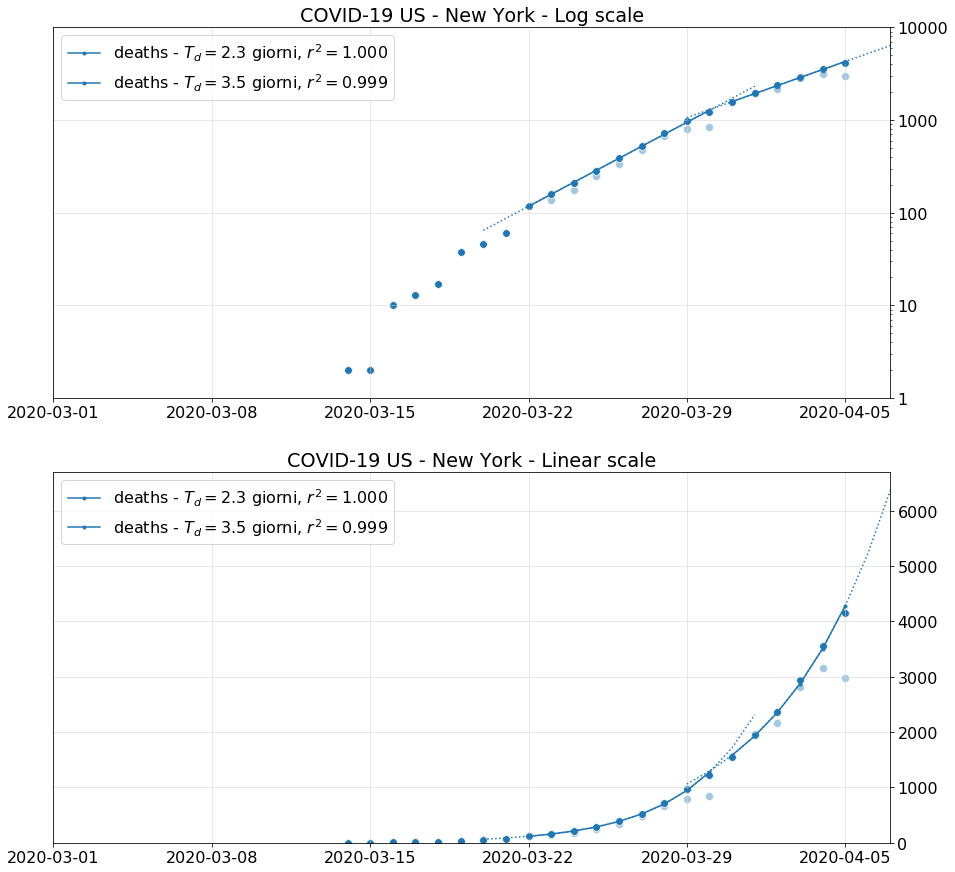

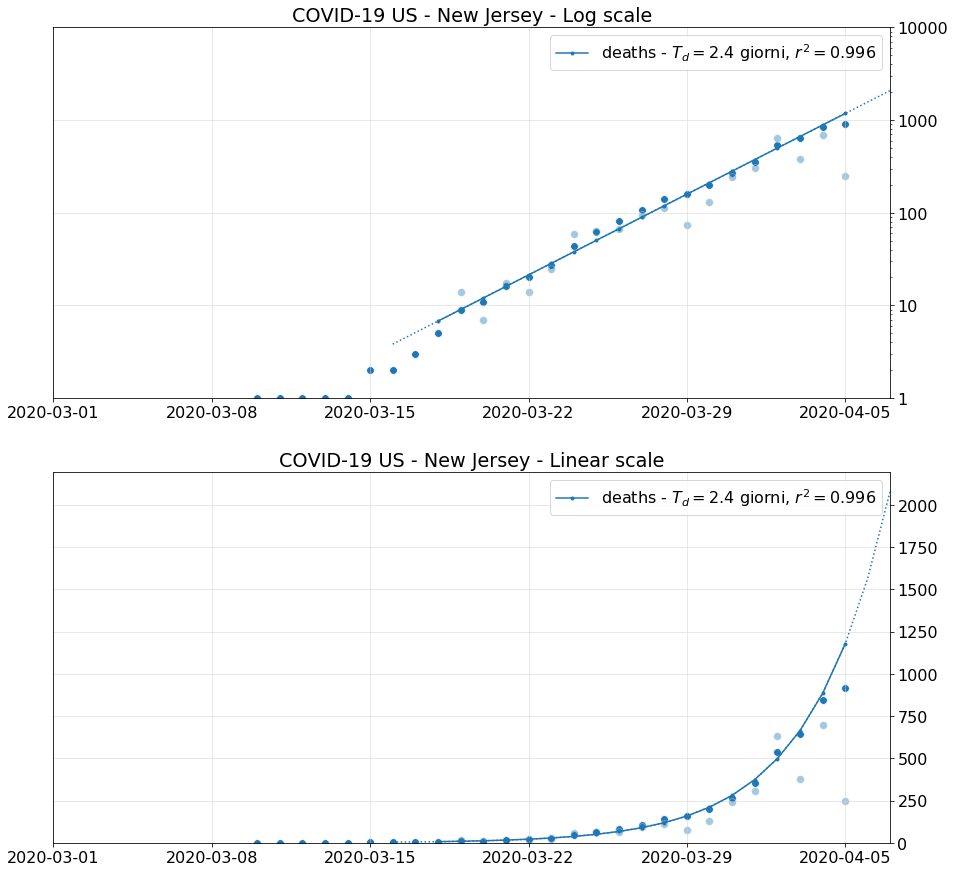

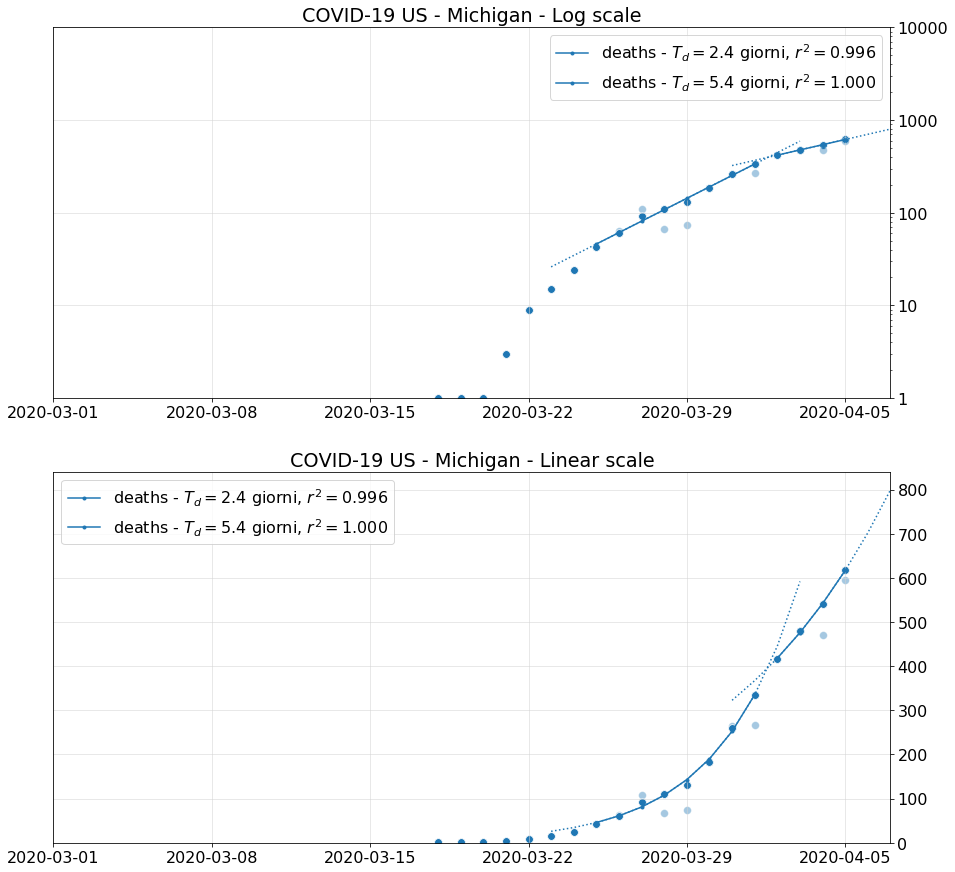

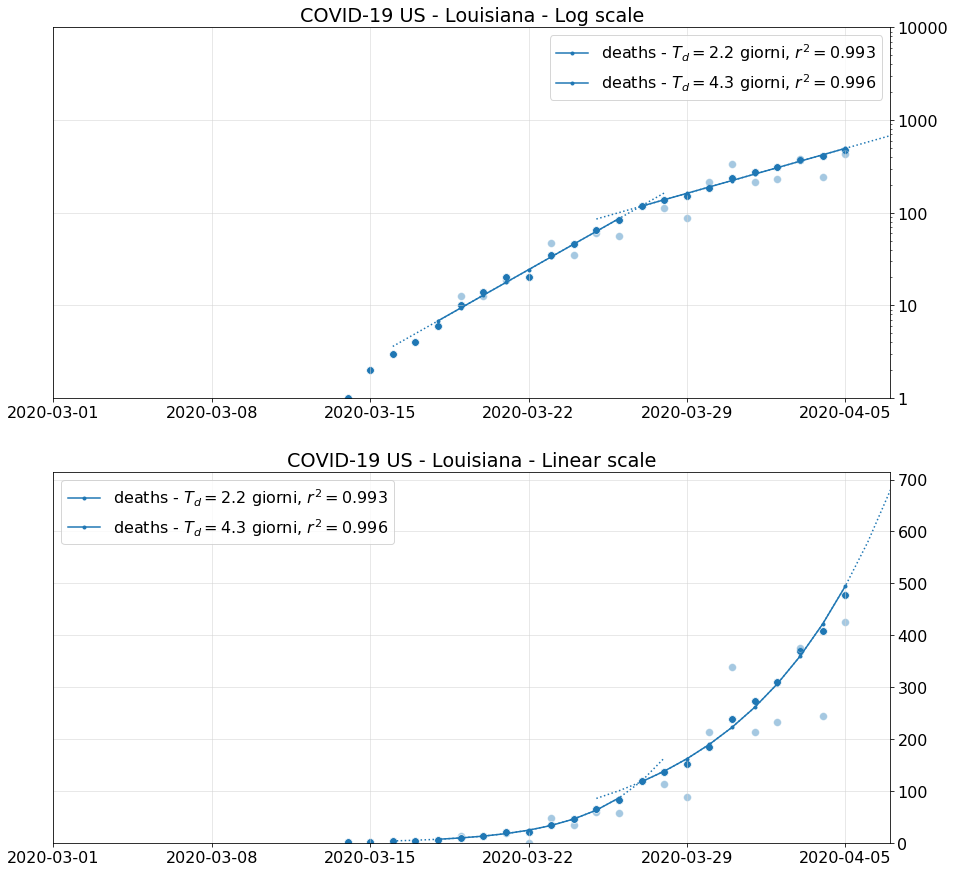

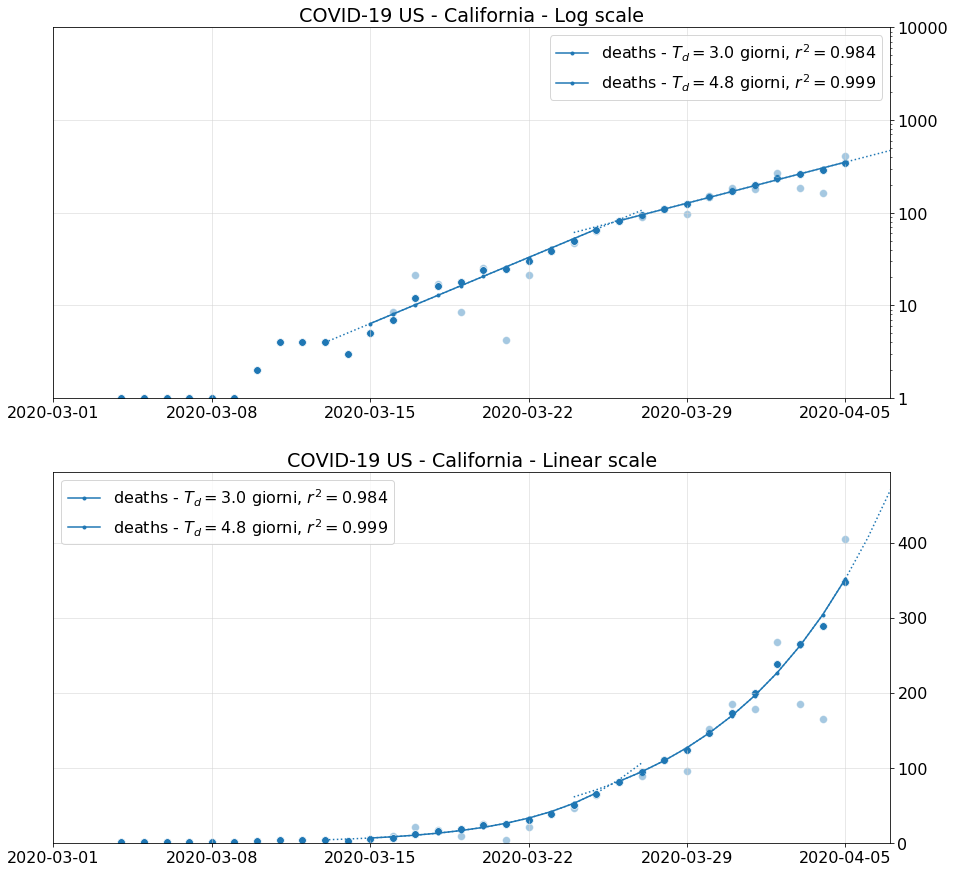

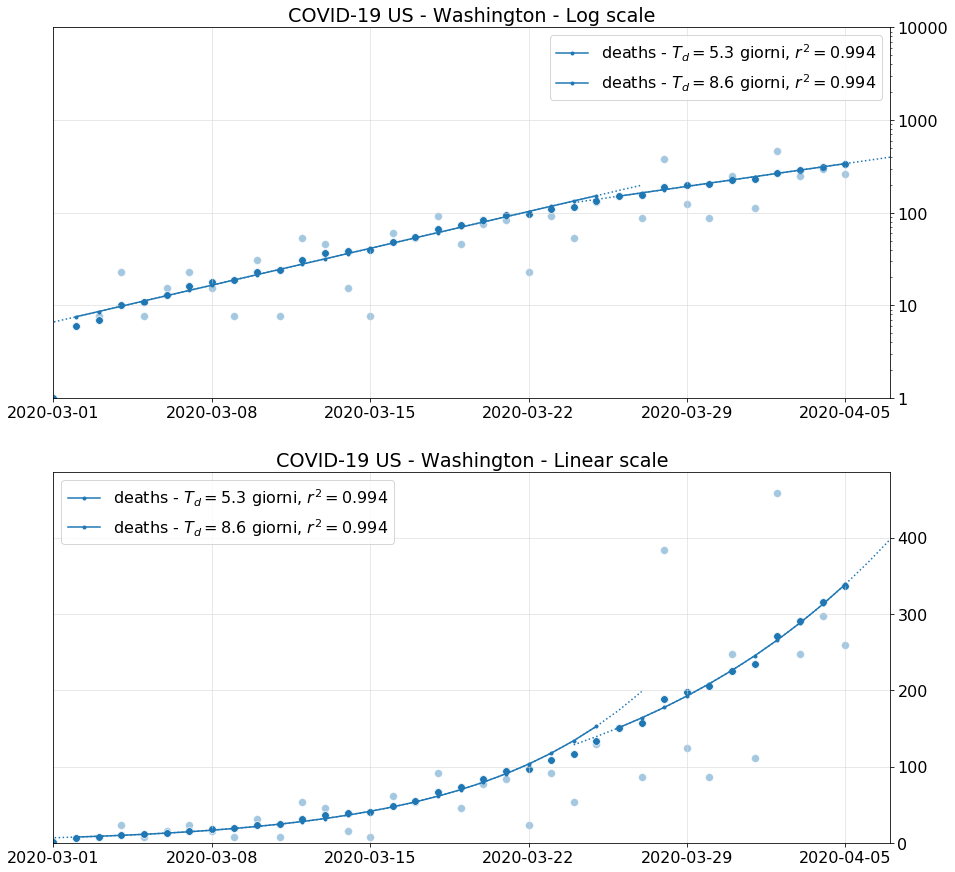

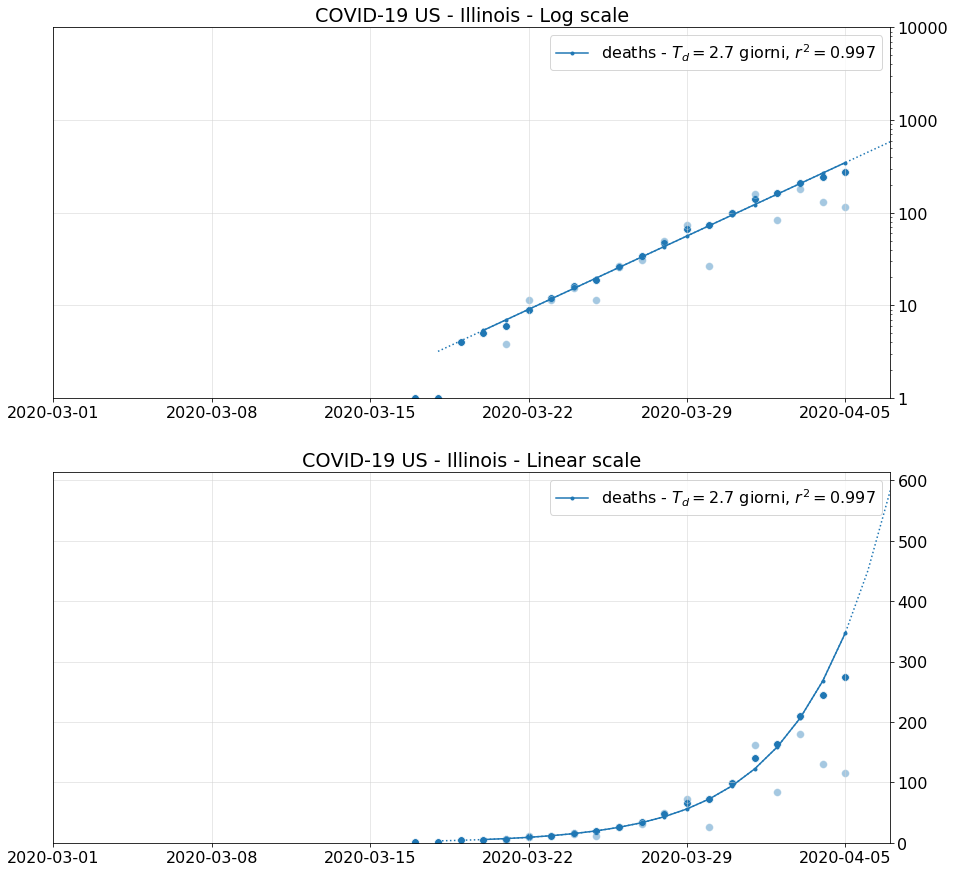

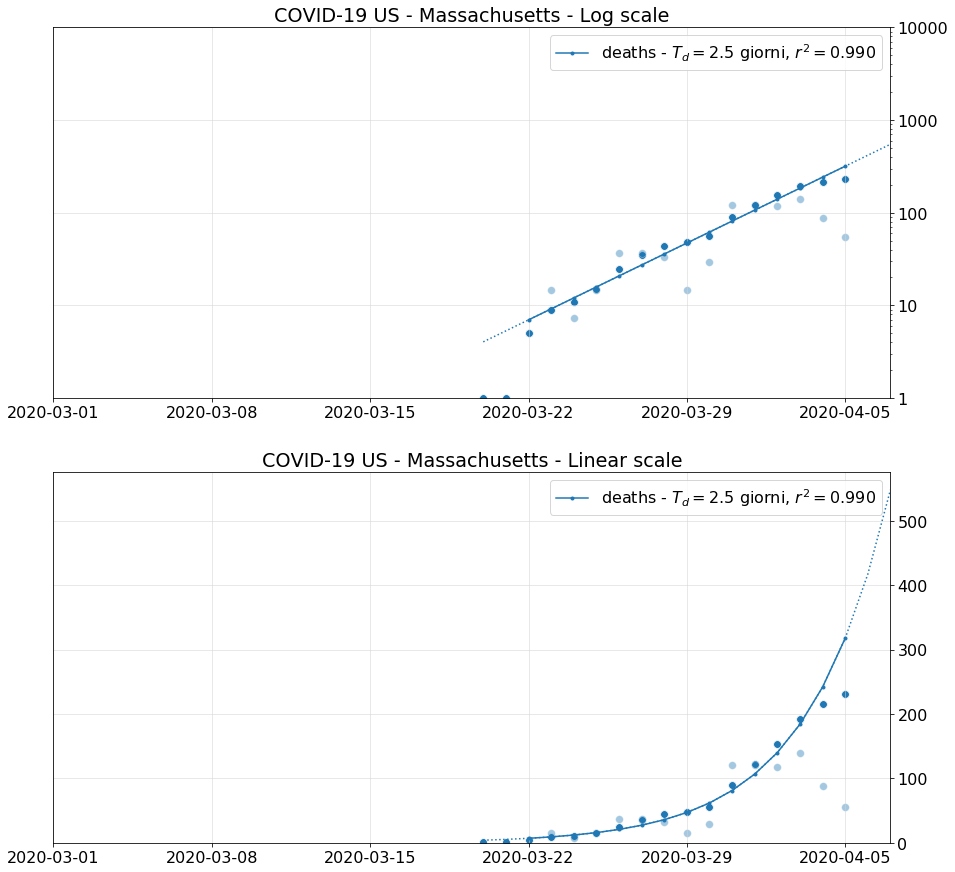

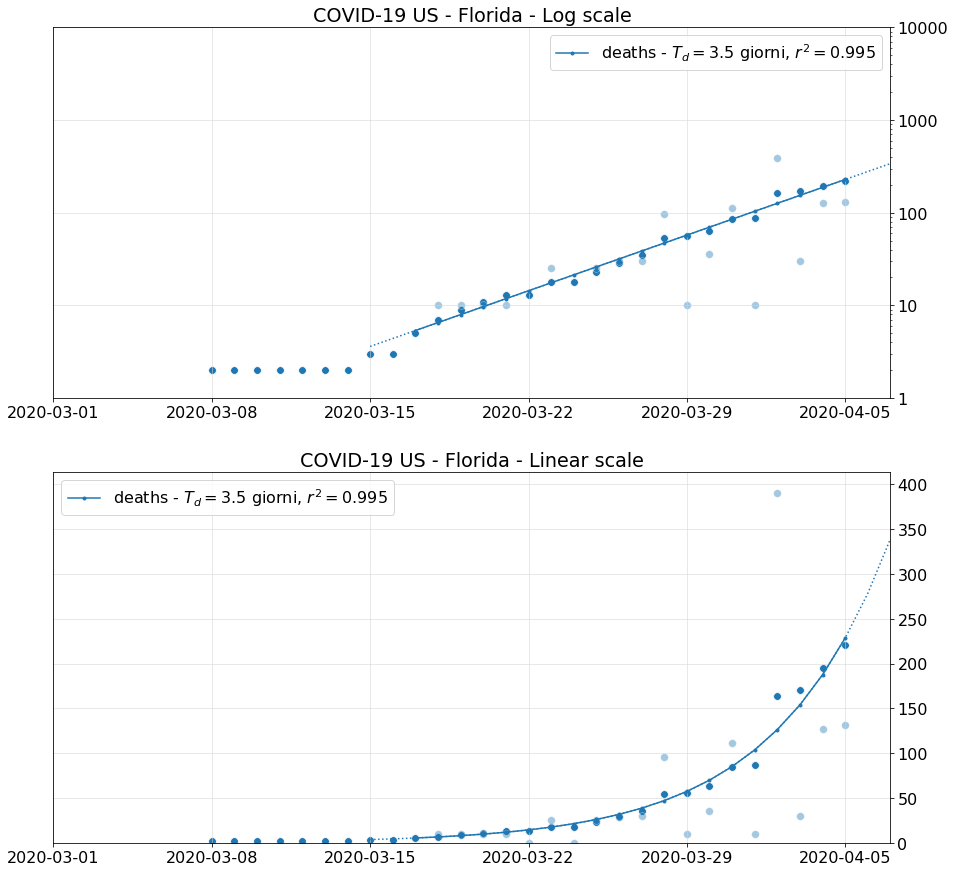

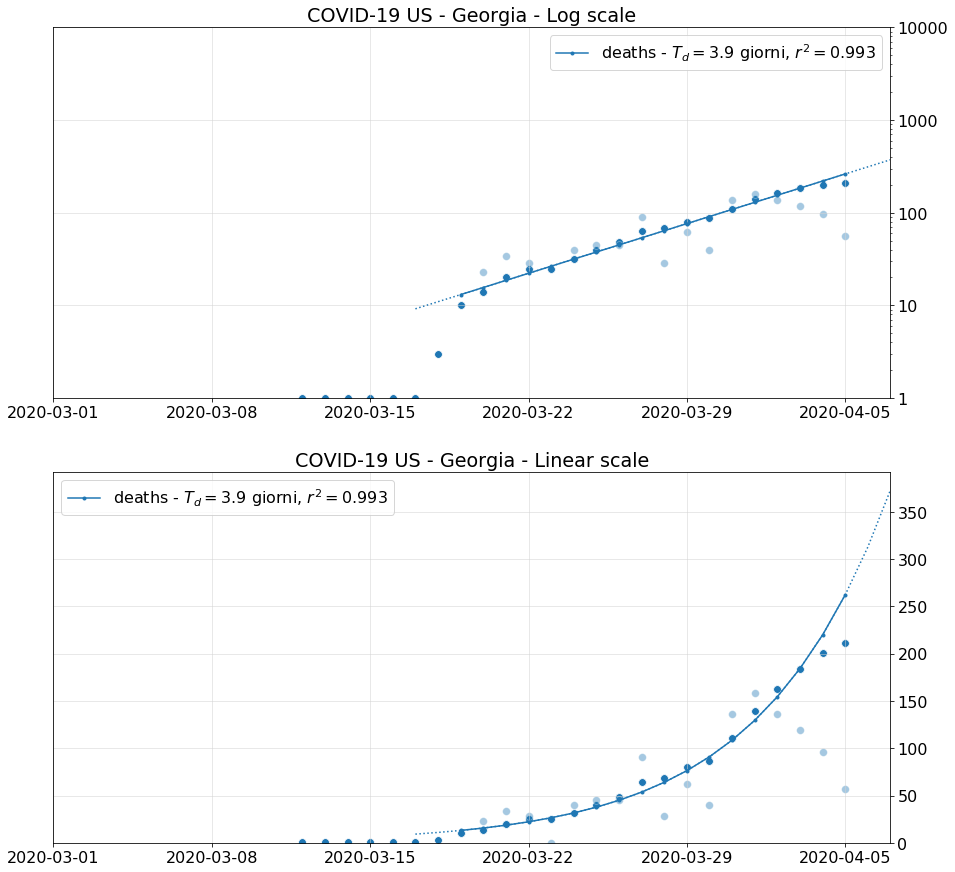

In [47]:
for region, fit_kinds in list(region_fits.items()):
    _, ax = plt.subplots(2, subplot_kw={'xlim': XLIM})
    ax[0].set(yscale='log', ylim=(1, 10000)) 
    ax[0].set_title(f'COVID-19 {region} - Log scale')
    ax[0].yaxis.tick_right()
    ax[0].yaxis.grid(color='lightgrey', linewidth=0.5)
    ax[0].xaxis.grid(color='lightgrey', linewidth=0.5)

    ax[1].set_title(f'COVID-19 {region} - Linear scale')
    ax[1].yaxis.tick_right()
    ax[1].yaxis.grid(color='lightgrey', linewidth=0.5)
    ax[1].xaxis.grid(color='lightgrey', linewidth=0.5)

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        for fit in fits:
            covid19.plot.plot_data(ax[0], data[region][kind], color=color)
            covid19.plot.plot(ax[0], data[region][kind], fit, label=kind, color=color, date_interval=5)
            covid19.plot.plot_data(ax[1], data[region][kind], color=color)
            covid19.plot.plot(ax[1], data[region][kind], fit, label=kind, color=color, date_interval=5)
    ax[1].set(ylim=(0, None)) 
